In [1]:
# read j3 wrf ts files

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils_solar import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram
import matplotlib.colors as mcolors

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
wrf_dt = 6

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3wrf.csv', index_col=0)

# obs
armbeatm_ncs = obs_dir+'sgparmbeatmC1.c1/sgparmbeatmC1.c1.20180101.003000.nc'
# obs bowen_ratio is nan...!

# 1 obs height in m, to match wrf's heights
share_height = 25

co2flx25m = xr.open_mfdataset(co2flx25m_ncs)

# plotting variables
co2flx25m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)']}

In [8]:
co2flx25m['height']

<xarray.DataArray 'height' (height: 512)>
array([1.5000e+01, 6.0000e+01, 1.0500e+02, ..., 2.2920e+04, 2.2965e+04,
       2.3010e+04], dtype=float32)
Coordinates:
  * height   (height) float32 15.0 60.0 105.0 ... 2.292e+04 2.296e+04 2.301e+04
Attributes:
    long_name:      Height above ground level
    units:          m
    axis:           Z
    positive:       up
    standard_name:  height
    bounds:         height_bounds

In [9]:
co2flx25m

<xarray.Dataset>
Dimensions:                    (bound: 2, height: 512, pressure: 37, time: 8760)
Coordinates:
  * time                       (time) datetime64[ns] 2018-01-01T00:30:00 ... ...
  * pressure                   (pressure) float32 1e+03 975.0 ... 125.0 100.0
  * height                     (height) float32 15.0 60.0 ... 2.301e+04
Dimensions without coordinates: bound
Data variables:
    base_time                  datetime64[ns] ...
    time_offset                (time) datetime64[ns] dask.array<chunksize=(8760,), meta=np.ndarray>
    time_bounds                (time, bound) datetime64[ns] dask.array<chunksize=(8760, 2), meta=np.ndarray>
    pressure_bounds            (pressure, bound) float32 dask.array<chunksize=(37, 2), meta=np.ndarray>
    height_bounds              (height, bound) float32 dask.array<chunksize=(512, 2), meta=np.ndarray>
    height_10m                 float32 ...
    height_2m                  float32 ...
    u_wind_sfc                 (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    v_wind_sfc                 (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    relative_humidity_sfc      (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    pressure_sfc               (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    precip_rate_sfc            (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    sensible_heat_flux_baebbr  (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    latent_heat_flux_baebbr    (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    temperature_sfc            (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    sensible_heat_flux_qcecor  (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    latent_heat_flux_qcecor    (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    temperature_p              (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    temperature_h              (time, height) float32 dask.array<chunksize=(8760, 512), meta=np.ndarray>
    dewpoint_p                 (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    dewpoint_h                 (time, height) float32 dask.array<chunksize=(8760, 512), meta=np.ndarray>
    u_wind_p                   (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    u_wind_h                   (time, height) float32 dask.array<chunksize=(8760, 512), meta=np.ndarray>
    v_wind_p                   (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    v_wind_h                   (time, height) float32 dask.array<chunksize=(8760, 512), meta=np.ndarray>
    relative_humidity_p        (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    relative_humidity_h        (time, height) float32 dask.array<chunksize=(8760, 512), meta=np.ndarray>
    u_wind_nwp_p               (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    v_wind_nwp_p               (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    omega_nwp_p                (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    temperature_nwp_p          (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    relative_humidity_nwp_p    (time, pressure) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
    lat                        float32 ...
    lon                        float32 ...
    alt                        float32 ...
Attributes:
    Conventions:           ARM-1.2
    command_line:          idl -R -n armbeatm -s sgp -f C1 -b 20180101 -e 201...
    title:                 ARM Best Estimate (ARMBE) Product, atmospheric pro...
    description:           ARM Best Estimate hourly averaged qc controlled pr...
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    platform_id:           armbeatm
    avera

In [10]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=[share_height], 
                         height_var='ph', agl=True)

    return ds

KeyError: 'sensible_heat_flux'

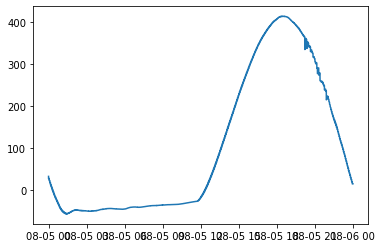

In [11]:
for col in data_dir_df.columns:

    eval_date = col

    date_col = data_dir_df[eval_date]

    c1_file_name = 'z.c1.d02'

    wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
    c1_mynn_file_path = wrf_mynn_dir+c1_file_name
    mynn_tower = Tower(c1_mynn_file_path)

    wrf_edmf_dir = wrf_runs_dir+date_col['edmf']+'/'
    c1_edmf_file_path = wrf_edmf_dir+c1_file_name
    edmf_tower = Tower(c1_edmf_file_path)

    # # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_mynn_ds = read_tower_to_ds(mynn_tower, wrf_start, wrf_dt)
    wrf_edmf_ds = read_tower_to_ds(edmf_tower, wrf_start, wrf_dt)

    wrf_mynn_ds = wrf_mynn_ds.sel(datetime=slice(eval_date, eval_date))
    wrf_edmf_ds = wrf_edmf_ds.sel(datetime=slice(eval_date, eval_date))

    co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))
    
    wrf_dict = {'mynn': wrf_mynn_ds, 'edmf': wrf_edmf_ds}
    
    for wrf_run, wrf_ds in wrf_dict.items(): 

        for wrf_var, var in co2flx25m_dict.items(): 

        #     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            plt.plot(wrf_ds['datetime'], wrf_ds[wrf_var], label='wrf')
            plt.plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

            plt.title(var[0]+': '+wrf_run+' vs '+co2flx25m_ds.platform_id+': '+eval_date)
            plt.ylabel(var[1])
            plt.axhline(color='grey', linestyle='--')
            plt.tick_params(labelrotation=90)
            plt.legend()

#             plt.savefig('plots_01d/'+eval_date+'_'+wrf_run+'_'+wrf_var+'.pdf')

            plt.show()

In [8]:
# height above AGL
mynn_tower.height = np.mean(mynn_tower.ph, axis=0)
# mynn_tower.height += mynn_tower.stationz
print(mynn_tower.height)

[   2.63752421    7.88807689   13.13864797   18.39014757   23.64284261
   29.06016081   34.72420346   40.6346329    46.83234947   53.359063
   60.21534644   67.44211161   75.04000598   82.96925981   91.2707069
  100.02685251  109.19805651  118.82574136  128.95147551  139.53562657
  150.66149214  162.37150151  174.62597329  187.4670773   200.97927549
  215.16447869  230.02464483  245.60429313  261.98797498  279.17848736
  297.17989611  316.07810243  335.96097357  356.79140128  378.61566806
  401.56525823  425.60427498  450.82351957  477.31562945  505.08825933
  534.91227013  567.6928185   603.70736544  643.28147059  686.74626344
  734.44001801  786.83802556  844.34100073  907.45206847  976.73644305
 1052.6945937  1135.98269976 1227.32464597 1327.42986697 1437.04638261
 1557.10487201 1688.54038849 1832.25820704 1989.38803431 2161.08995392]
